     block, center = (0,0,0)
          size (1,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)


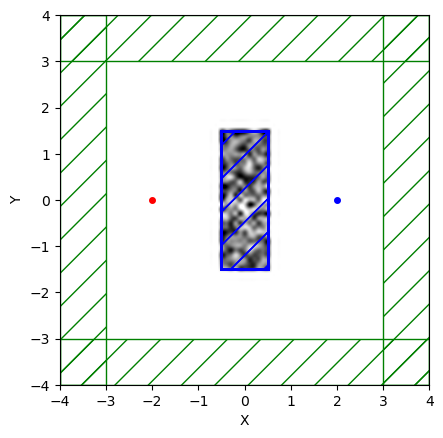

     block, center = (0,0,0)
          size (1,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)


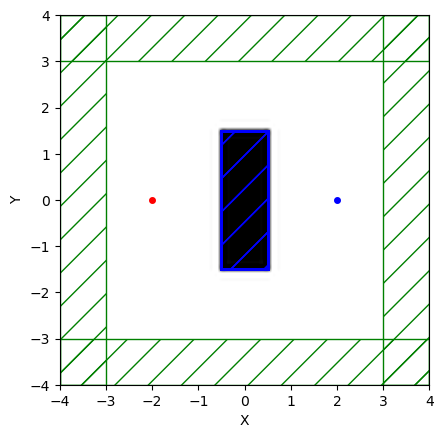

In [8]:
## dielectric lens ## 
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import nlopt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

#mp.verbosity(0)

Si = mp.Medium(index=3.4)

cell_size = mp.Vector3(8, 8, 0)
pml_layers = [mp.PML(1.0)]
resolution = 10

# source
source_center = [-2, 0, 0]
fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
sources = [mp.Source(src=mp.GaussianSource(frequency=fcen,fwidth=fwidth),
                     component=mp.Ez,
                     center=source_center,
                     size=mp.Vector3(0,0,0))]

# design region
Lx = 1
Ly = 3
design_region_resolution = int(resolution)
Nx = design_region_resolution * Lx + 1
Ny = design_region_resolution * Ly + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny,0),
                                   mp.air,
                                   Si,
                                   grid_type="U_MEAN")
design_region = mpa.DesignRegion(design_variables,
                                 volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(Lx,Ly,0)))                             

geometry = [mp.Block(center=design_region.center,
                     size=design_region.size,
                     material=design_variables)]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    eps_averaging=False,
    resolution=resolution
)

# adjoint optimization setup
monitor_position = mp.Vector3(2, 0, 0)
monitor_size = mp.Vector3(0, 0, 0)
FourierFields = mpa.FourierFields(sim,
                                  mp.Volume(center=monitor_position,
                                            size=monitor_size),
                                  mp.Ez,
                                  yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.abs(fields) ** 2



opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
    decay_by=1e-6
)

x0 = np.random.rand(Nx * Ny)
opt.update_design([x0])

opt.plot2D(True, frequency=1/1.55)
plt.show()

x0 = 0.5 * np.ones((Nx * Ny, ))
opt.update_design([x0])

opt.plot2D(True)
plt.show()

In [9]:
evaluation_history = []
sensitivy = [0]

def f(x, grad):
    f0, dJ_du = opt([x])
    f0 = f0[0]
    if grad.size > 0:
        grad[:] = np.squeeze(dJ_du)
    evaluation_history.append(np.real(f0))
    sensitivy[0] = dJ_du
    return np.real(f0)

algorithm = nlopt.LD_MMA
n = Nx * Ny
maxeval = 10

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(0)
solver.set_upper_bounds(1)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)

x = solver.optimize(x0)

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000136137 s
Working in 2D dimensions.
Computational cell is 8 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0034101 s
-----------
run 0 finished at t = 398.40000000000003 (7968 timesteps)
Starting adjoint run...
on time step 41057 (time=2052.85), 9.74266e-05 s/step
on time step 79123 (time=3956.15), 0.000105082 s/step
on time step 119087 (time=5954.35), 0.000100091 s/step
on time step 160394 (time=8019.7), 9.68372e-05 s/step
on time step 200315 (time=10015.8), 0.000100198 s/step
on time step 240285 (time=12014.2), 0.000100076 s/step
on time step 281752 (time=14087.6), 9.64624e-05 s/step
on time step 322002 (time=16100.1), 9.938e-05 s/step
on time step 362873 (time=18143.7), 9.78698e-05 s/step
on time step 403806 (time=20190.3), 9.77215e-05 s/step
on time step 445595 (time=22279.8), 9.57201e-05 

KeyboardInterrupt: 